# chapitre 2 production

In [32]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

On va faire un paquet de données a partir de photo d'ours

on utilise notre ressource azure pour faire une clé api microsoft

on en télécharge et on en affiche une

In [33]:
key = os.environ.get('AZURE_SEARCH_KEY', 'key')

In [34]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

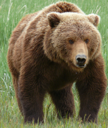

In [35]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

vu que ça marche on peut créer un dossier d'images

In [36]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

on vérifie que ça soit remplie

In [37]:
fns = get_image_files(path)
fns

(#439) [Path('bears/black/00000148.jpg'),Path('bears/black/00000049.jpg'),Path('bears/black/00000095.jpg'),Path('bears/black/00000105.jpg'),Path('bears/black/00000134.jpg'),Path('bears/black/00000056.jpg'),Path('bears/black/00000060.jpg'),Path('bears/black/00000046.jpg'),Path('bears/black/00000121.jpg'),Path('bears/black/00000119.jpg')...]

et si il y a des ratés

In [38]:
failed = verify_images(fns)
failed

(#0) []

il y en a en effet on va donc le(s) supprimer

In [39]:
failed.map(Path.unlink);

c'est une classe pour ranger des dataloader

In [40]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

on fait un data loader à partir du dataset d'ours créé

In [41]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

on récupère le path pour indiquer a fastai la source

In [42]:
dls = bears.dataloaders(path)

on demande d'afficher une fournée du dataset

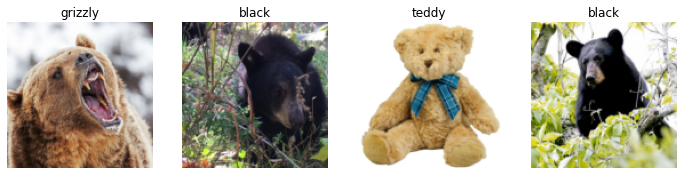

In [43]:
dls.valid.show_batch(max_n=4, nrows=1)

toutes les images n'ayant pas la meme taille on va les resize en cropant une partie de l'image plutot que de la déformer ou d'avoir des images avec beaucoup de rien

ça aidera également l'ia a reconnaitre des ours meme si ceux si sont coupés

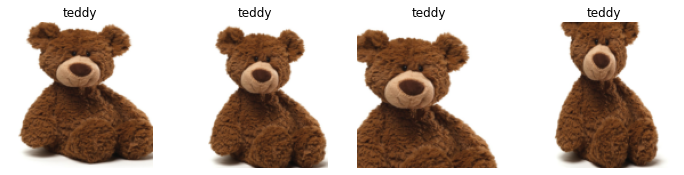

In [44]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

on peut également déformer les images et les cropper pour la même raison, c'est de l'augmentation et c'est ça qui sera utilisé pour entrainer l'ia

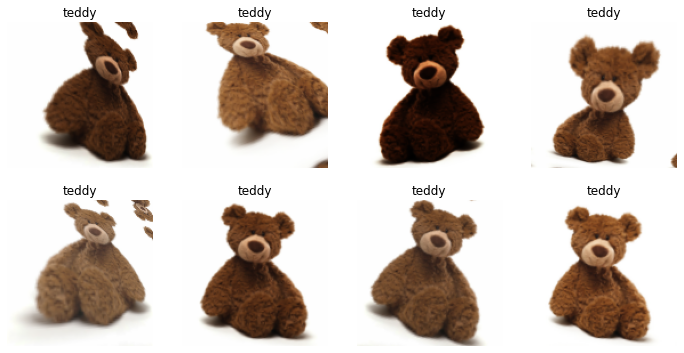

In [45]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

on va ensuite entrainer le modele et s'en servir pour nétoyer les données

on va donc 'augmenter' les images et lancer l'apprentissage

In [46]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [47]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

pour savoir si l'entrainement s'est fait correctement on va lancer une matrice de confusion et voir si c'est une catastrophe

plus c'est sombre (haut) dans la diagonale mieux c'est

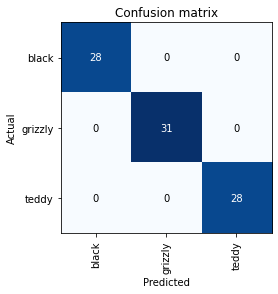

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

ensuite on va regarder un exemple pour constater

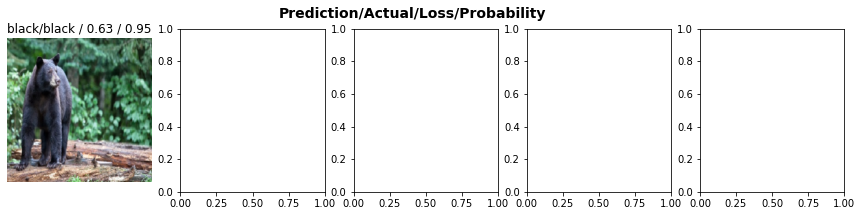

In [49]:
interp.plot_top_losses(5, nrows=1)

pour aider l'ia on peut clean manuellement (ca va rien supprimer mais juste changer les tags

In [50]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

après avoir fait ça on peut exporter l'application

In [51]:
learn.export()

In [52]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [53]:
learn_inf = load_learner(path/'export.pkl')

In [54]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([5.0246e-08, 1.0000e+00, 3.2678e-09]))

In [55]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

ensuite on peut refaire ce qu'on a fait dans dans exocode mais on va améliorer ça

In [62]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [63]:
img = PILImage.create(btn_upload.data[-1])

In [64]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [65]:
pred,pred_idx,probs = learn_inf.predict(img)

In [66]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred


Label(value='Prediction: teddy; Probability: 0.9831')

In [67]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [68]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [69]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()